# Machine Learning Modelling

## Hotel Booking - Price Prediction

### Import Libraries

In [1]:
## General
import math
import pickle
import numpy as np
import pandas as pd

## EDA
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
colour_palette = sns.color_palette("hls", 8)

## Machine Learning
# Pre-Processing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler      # Remove Mean and scale to Unit Variance
from sklearn.preprocessing import PowerTransformer    # Log Transformation
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVR
import lightgbm as ltb
import xgboost as xgb
import catboost as cb

### Import Dataset

In [2]:
## Importing Data
data_hotel_bookings = pd.read_csv('../../Dataset/hotel_booking/hotel_bookings.csv')

## Understanding Data I
data_hotel_bookings.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


In [3]:
## Understanding Data II
print(data_hotel_bookings.dtypes)

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [4]:
## Understanding Data III
data_hotel_bookings

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07


### Pre-Processing

In [5]:
## Check Missing Data
data_hotel_bookings.isnull().sum()[data_hotel_bookings.isnull().sum() > 0]

children         4
country        488
agent        16340
company     112593
dtype: int64

In [6]:
## Fill Missing Data

# For Children
data_hotel_bookings.children.fillna(0, inplace = True)

# For Country
data_hotel_bookings.country.fillna("Unknown", inplace = True)

# For Agent
data_hotel_bookings.loc[data_hotel_bookings.agent.isnull() == False, 'agent'] = 'Agent'
data_hotel_bookings.agent.fillna("No Agent", inplace = True)

# For Company 
data_hotel_bookings.loc[data_hotel_bookings.company.isnull() == False, 'company'] = 'Corporate'
data_hotel_bookings.company.fillna("No Company", inplace = True)

# Re-Confirm 
data_hotel_bookings.isnull().sum()[data_hotel_bookings.isnull().sum() > 0]

Series([], dtype: int64)

In [7]:
## Changing Data Types
data_hotel_bookings['children'] = data_hotel_bookings['children'].astype('int') 

In [8]:
## Adjust to suit Streaming Data - Hotel Reservation
data_hotel_bookings.loc[(data_hotel_bookings['meal'] == 'Undefined'), 'meal']= 'SC'
data_hotel_bookings.loc[(data_hotel_bookings['required_car_parking_spaces'] > 1), 'required_car_parking_spaces']= 1

In [9]:
## Separating Data
data_hotel_bookings_resort = data_hotel_bookings.loc[data_hotel_bookings["hotel"] == "Resort Hotel"]
data_hotel_bookings_city = data_hotel_bookings.loc[data_hotel_bookings["hotel"] == "City Hotel"]

In [10]:
## Selecting Columns in both Hotel Booking & Hotel Reservation
data_hotel_bookings_city.drop(['hotel', 'arrival_date_week_number', 'babies', 'country', 'distribution_channel', 
                               'assigned_room_type', 'booking_changes', 'deposit_type', 'agent', 'company', 'is_canceled', 
                               'days_in_waiting_list', 'customer_type', 'reservation_status', 'reservation_status_date'], 
                              axis = 1, inplace = True)

print(data_hotel_bookings_city.dtypes)

lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                            int32
meal                               object
market_segment                     object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
adr                               float64
required_car_parking_spaces         int64
total_of_special_requests           int64
dtype: object


C:\Users\KMwong\AppData\Local\Temp\ipykernel_6364\4024995158.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_hotel_bookings_city.drop(['hotel', 'arrival_date_week_number', 'babies', 'country', 'distribution_channel',


### Feature Engineering

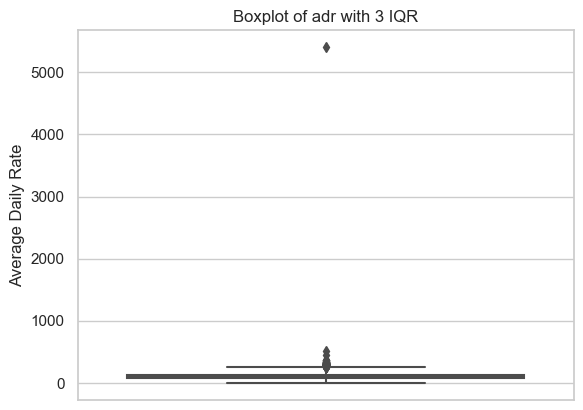

In [11]:
# Outlier Analysis for adr
adr_box = sns.boxplot(y = data_hotel_bookings_city["adr"], whis=3.0)
adr_box.set(ylabel = "Average Daily Rate",
                 title = "Boxplot of adr with 3 IQR")
plt.show()

C:\Users\KMwong\AppData\Local\Temp\ipykernel_6364\688556102.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_hotel_bookings_city.drop(index = [row for row in data_hotel_bookings_city.index
C:\Users\KMwong\AppData\Local\Temp\ipykernel_6364\688556102.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_hotel_bookings_city.drop(index = [row for row in data_hotel_bookings_city.index


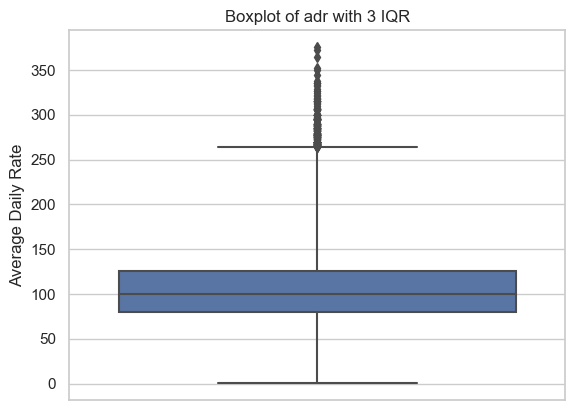

In [12]:
# Further Cleaning Data for adr
data_hotel_bookings_city.drop(index = [row for row in data_hotel_bookings_city.index 
                                           if 400 < data_hotel_bookings_city.loc[row, 'adr']], 
                                      inplace = True)
data_hotel_bookings_city.drop(index = [row for row in data_hotel_bookings_city.index 
                                            if 0 >= data_hotel_bookings_city.loc[row, 'adr']], 
                                      inplace = True)

# Visualising Box Again
adr_cleaned_box = sns.boxplot(y = data_hotel_bookings_city["adr"], whis=3.0)
adr_cleaned_box.set(ylabel = "Average Daily Rate",
                 title = "Boxplot of adr with 3 IQR")
plt.show()

In [13]:
# Rounding adr to nearest integer and convert to int
data_hotel_bookings_city.adr = data_hotel_bookings_city.adr.round()
data_hotel_bookings_city.adr = data_hotel_bookings_city.adr.astype('int')
# print(data_hotel_bookings_city.adr)

C:\Users\KMwong\AppData\Local\Temp\ipykernel_6364\3460971230.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_hotel_bookings_city.adr = data_hotel_bookings_city.adr.round()
C:\Users\KMwong\AppData\Local\Temp\ipykernel_6364\3460971230.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_hotel_bookings_city.adr = data_hotel_bookings_city.adr.astype('int')


In [14]:
## Encoding

# OneHotEncoder (Run Once only)

# perform one-hot encoding for the market_segment column
market_segment_one_hot = pd.get_dummies(data_hotel_bookings_city['market_segment'], prefix='market_segment')
# concatenate the one-hot encoded columns to the original dataset
data_hotel_bookings_city = pd.concat([data_hotel_bookings_city, market_segment_one_hot], axis=1)
# drop the original customer_type column
data_hotel_bookings_city.drop('market_segment', axis=1, inplace=True)

# perform one-hot encoding for the arrival_date_month column
arrival_date_month_one_hot = pd.get_dummies(data_hotel_bookings_city['arrival_date_month'], prefix='arrival_date_month')
# concatenate the one-hot encoded columns to the original dataset
data_hotel_bookings_city = pd.concat([data_hotel_bookings_city, arrival_date_month_one_hot], axis=1)
# drop the original arrival_date_month column
data_hotel_bookings_city.drop('arrival_date_month', axis=1, inplace=True)

# perform one-hot encoding for the meal column
meal_one_hot = pd.get_dummies(data_hotel_bookings_city['meal'], prefix='meal')
# concatenate the one-hot encoded columns to the original dataset
data_hotel_bookings_city = pd.concat([data_hotel_bookings_city, meal_one_hot], axis=1)
# drop the original meal column
data_hotel_bookings_city.drop('meal', axis=1, inplace=True)

# perform one-hot encoding for the reserved_room_type column
reserved_room_type_one_hot = pd.get_dummies(data_hotel_bookings_city['reserved_room_type'], prefix='reserved_room_type')
# concatenate the one-hot encoded columns to the original dataset
data_hotel_bookings_city = pd.concat([data_hotel_bookings_city, reserved_room_type_one_hot], axis=1)
# drop the original reserved_room_type column
data_hotel_bookings_city.drop('reserved_room_type', axis=1, inplace=True)


# LabelEncoder

# create a LabelEncoder object
le = LabelEncoder()

# # apply LabelEncoder to the reservation_status column ('Canceled': -1, 'No-Show': 0, 'Check-Out': 1)
# mapping_rs = {'Canceled': -1, 'No-Show': 0, 'Check-Out': 1}
# data_hotel_bookings['reservation_status'] = data_hotel_bookings['reservation_status'].map(mapping_rs)
# data_hotel_bookings['reservation_status'] = le.fit_transform(data_hotel_bookings['reservation_status'])
# data_hotel_bookings['reservation_status'] = data_hotel_bookings['reservation_status'].map(dict(zip(range(3), mapping_rs.values())))

# # apply LabelEncoder to the deposit_type column ('Non-Refund': -1, 'No Deposit': 0, 'Refundable': 1)
# mapping_dt = {'Non Refund': -1, 'No Deposit': 0, 'Refundable': 1}
# data_hotel_bookings['deposit_type'] = data_hotel_bookings['deposit_type'].map(mapping_dt)
# data_hotel_bookings['deposit_type'] = le.fit_transform(data_hotel_bookings['deposit_type'])
# data_hotel_bookings['deposit_type'] = data_hotel_bookings['deposit_type'].map(dict(zip(range(3), mapping_dt.values())))

# print the result
data_hotel_bookings_city

,lead_time,arrival_date_year,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,...,meal_FB,meal_HB,meal_SC,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G
40061,88,2015,1,0,4,2,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
40062,65,2015,1,0,4,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
40063,92,2015,1,2,4,2,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
40064,100,2015,2,0,2,2,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
40065,79,2015,2,0,3,2,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,23,2017,30,2,5,2,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
119386,102,2017,31,2,5,3,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
119387,34,2017,31,2,5,2,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
119388,109,2017,31,2,5,2,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [137]:
## Only Run This For Classification Models (Not Regression Models)
# Create categories for the adr column (1: 0-50 dollars, 2: 51-100 dollars, ..., 350-400 dollars)
bins = [-1, 50, 100, 150, 200, 250, 300, 350, 400]
labels = [1, 2, 3, 4, 5, 6, 7, 8]
data_hotel_bookings_city['adr_category'] = pd.cut(data_hotel_bookings_city['adr'], bins=bins, labels=labels)

# print the result
data_hotel_bookings_city[['adr', 'adr_category']].max()

adr             376
adr_category      8
dtype: int64

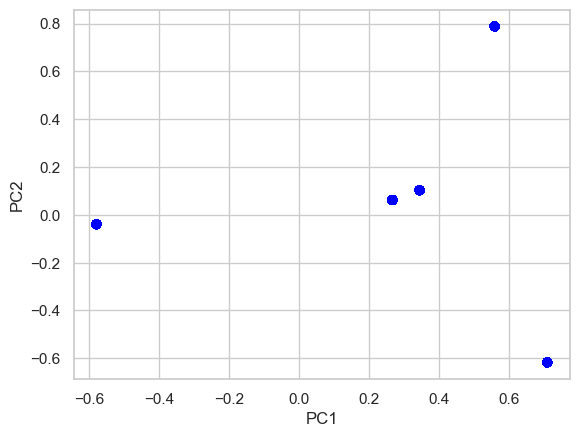

Explained variance ratios: [0.31870875 0.24779181 0.22103578 0.20000683 0.01245683]


In [15]:
## Principal Component Analysis (PCA)

# Select variables for PCA
X = data_hotel_bookings_city[['market_segment_Direct', 'market_segment_Groups', 'market_segment_Offline TA/TO', 'market_segment_Online TA', 'market_segment_Undefined']]

# Add adr as target variable
y = data_hotel_bookings_city['adr']

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create scatter plot of first two principal components
colors = ['red' if x == 1 else 'blue' for x in y]
plt.scatter(X_pca[:,0], X_pca[:,1], c=colors)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


X = StandardScaler().fit_transform(X)

pca = PCA()
principalComponents = pca.fit_transform(X)

explained_var = pca.explained_variance_ratio_
print("Explained variance ratios:", explained_var)

In [16]:
## Correlation Matrix
data_hotel_bookings_city.corr()

,lead_time,arrival_date_year,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,...,meal_FB,meal_HB,meal_SC,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G
lead_time,1.000000,0.023952,0.013844,-0.031570,0.050700,0.108199,-0.054733,-0.088560,0.128606,-0.058858,...,-0.003356,0.137314,-0.140243,0.143439,0.005881,-0.002162,-0.116372,-0.057200,-0.047908,-0.036585
arrival_date_year,0.023952,1.000000,-0.003181,0.033132,0.065684,0.063668,0.055440,-0.031585,-0.203012,0.020708,...,-0.035921,-0.103978,0.153636,-0.127693,-0.035479,-0.006126,0.112295,0.073614,0.024761,0.033467
arrival_date_day_of_month,0.013844,-0.003181,1.000000,0.000328,-0.012353,-0.002024,0.012135,-0.010336,-0.009846,0.000535,...,0.018028,0.007357,-0.012072,-0.020218,0.009927,0.001265,0.011851,0.007194,0.011110,0.002803
stays_in_weekend_nights,-0.031570,0.033132,0.000328,1.000000,0.199644,0.082173,0.037901,-0.063767,-0.037242,-0.020677,...,0.003573,-0.010542,0.001706,-0.087308,0.024486,-0.004673,0.074015,0.018705,0.018550,0.014768
stays_in_week_nights,0.050700,0.065684,-0.012353,0.199644,1.000000,0.088193,0.037217,-0.068433,-0.050350,-0.035595,...,-0.003815,-0.032968,-0.027871,-0.121812,0.023319,-0.000881,0.104144,0.035503,0.022302,0.022304
adults,0.108199,0.063668,-0.002024,0.082173,0.088193,1.000000,-0.008921,-0.153498,-0.036332,-0.105451,...,-0.034988,0.033365,0.004790,-0.266829,-0.068435,-0.003135,0.267983,0.067851,0.045934,0.070255
children,-0.054733,0.055440,0.012135,0.037901,0.037217,-0.008921,1.000000,-0.027336,-0.043711,-0.016389,...,-0.005359,-0.003541,-0.078697,-0.279379,0.147874,0.002863,-0.059534,0.065104,0.629704,0.208585
is_repeated_guest,-0.088560,-0.031585,-0.010336,-0.063767,-0.068433,-0.153498,-0.027336,1.000000,0.275357,0.449856,...,-0.003181,-0.041000,-0.040470,0.033280,-0.015786,0.005807,-0.026768,0.001002,-0.013130,-0.005997
previous_cancellations,0.128606,-0.203012,-0.009846,-0.037242,-0.050350,-0.036332,-0.043711,0.275357,1.000000,0.385596,...,-0.004168,0.010094,-0.064930,0.076817,-0.008021,0.002982,-0.064332,-0.018899,-0.025910,-0.014212
previous_bookings_not_canceled,-0.058858,0.020708,0.000535,-0.020677,-0.035595,-0.105451,-0.016389,0.449856,0.385596,1.000000,...,-0.001541,-0.020222,-0.023034,0.017916,-0.007646,-0.000840,-0.018904,0.015711,-0.009786,-0.005040


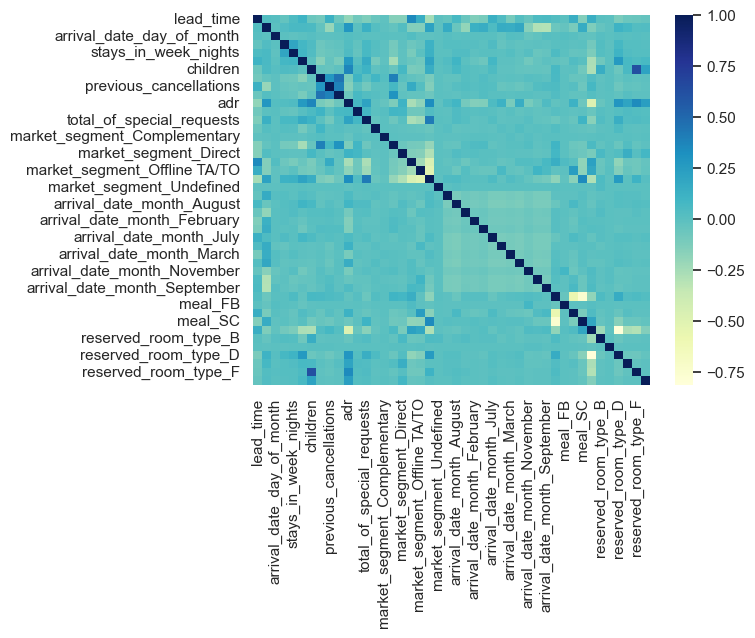

In [17]:
## Correlation Matrix Heatmap
sns.heatmap(data_hotel_bookings_city.corr(), cmap='YlGnBu') #, annot = True, annot_kws={"size":5})
plt.show()

In [18]:
## Feature Importance
corr_adr = data_hotel_bookings_city.corr()["adr"]
corr_adr.abs().sort_values(ascending = False)

adr                               1.000000
reserved_room_type_A              0.481209
children                          0.365179
reserved_room_type_F              0.348965
market_segment_Online TA          0.332869
reserved_room_type_D              0.290422
arrival_date_year                 0.278971
adults                            0.266716
market_segment_Groups             0.261283
reserved_room_type_G              0.241216
total_of_special_requests         0.214429
reserved_room_type_E              0.205093
lead_time                         0.192400
market_segment_Offline TA/TO      0.177976
arrival_date_month_May            0.149633
previous_cancellations            0.146733
arrival_date_month_February       0.139518
arrival_date_month_January        0.135284
meal_HB                           0.121625
market_segment_Corporate          0.121564
arrival_date_month_June           0.119723
market_segment_Direct             0.114021
arrival_date_month_March          0.109832
arrival_dat

In [19]:
## Selecting Features for Model Building
data_hotel_bookings_city_feature = data_hotel_bookings_city

data_hotel_bookings_city_feature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78119 entries, 40061 to 119389
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   lead_time                       78119 non-null  int64
 1   arrival_date_year               78119 non-null  int64
 2   arrival_date_day_of_month       78119 non-null  int64
 3   stays_in_weekend_nights         78119 non-null  int64
 4   stays_in_week_nights            78119 non-null  int64
 5   adults                          78119 non-null  int64
 6   children                        78119 non-null  int32
 7   is_repeated_guest               78119 non-null  int64
 8   previous_cancellations          78119 non-null  int64
 9   previous_bookings_not_canceled  78119 non-null  int64
 10  adr                             78119 non-null  int32
 11  required_car_parking_spaces     78119 non-null  int64
 12  total_of_special_requests       78119 non-null  int64
 

### Model Selection

In [20]:
## Splitting Data (80:20) Regression
x = data_hotel_bookings_city_feature.drop(columns = 'adr')
y = data_hotel_bookings_city_feature.adr 

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2, random_state=42)
x_train.shape, x_test.shape

((62495, 43), (15624, 43))

In [143]:
## Splitting Data (80:20) Classification
x = data_hotel_bookings_city_feature.drop(columns = ['adr', 'adr_category'])
y = data_hotel_bookings_city_feature.adr_category

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2, random_state=42)
x_train.shape, x_test.shape

((62495, 43), (15624, 43))

#### Regression Models

In [108]:
## Model : Linear Regression
# Finding linear relationship among more than two quantitative variables

lnr = LinearRegression()
lnr_model = lnr.fit(x_train, y_train)
lnr_y_pred = lnr_model.predict(x_test)

# Print Coefficients
print(f"Mean Squared Error: {mean_squared_error(y_test, lnr_y_pred)}")
print(f"RMSE: {math.sqrt(mean_squared_error(y_test, lnr_y_pred))}")
print(f"R2 Score: {r2_score(y_test, lnr_y_pred)}")

# # Plot Output
# plt.scatter(x_test, y_test, color="black")
# plt.plot(x_test, lnr_y_pred, color="blue", linewidth=3)
# plt.xticks(())
# plt.yticks(())
# plt.show()

Mean Squared Error: 489.4220036036281
RMSE: 22.122884161058842
R2 Score: 0.6483694501694387


In [21]:
## Model : Random Forest Regressor
# Meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to 
# improve the predictive accuracy and control over-fitting

rfr = RandomForestRegressor()
rfr_model = rfr.fit(x_train, y_train)
rfr_y_pred = rfr_model.predict(x_test)

# Print Coefficients
print(f"Mean Squared Error: {mean_squared_error(y_test, rfr_y_pred)}")
print(f"RMSE: {math.sqrt(mean_squared_error(y_test, rfr_y_pred))}")
print(f"R2 Score: {r2_score(y_test, rfr_y_pred)}")

Mean Squared Error: 184.7350694345881
RMSE: 13.59172797824427
R2 Score: 0.8672750845691859


In [110]:
## Model : Gradient Boosting Regressor
# Builds an additive model in a forward stage-wise fashion for the optimization of arbitrary differentiable loss functions. 
# In each stage a regression tree is fit on the negative gradient of the given loss function.

gbr = GradientBoostingRegressor()
gbr_model = gbr.fit(x_train, y_train)
gbr_y_pred = gbr_model.predict(x_test)

# Print Coefficients
print(f"Mean Squared Error: {mean_squared_error(y_test, gbr_y_pred)}")
print(f"RMSE: {math.sqrt(mean_squared_error(y_test, gbr_y_pred))}")
print(f"R2 Score: {r2_score(y_test, gbr_y_pred)}")

Mean Squared Error: 412.8186632858107
RMSE: 20.317939444880004
R2 Score: 0.7034059513411896


In [111]:
## Model : Stochastic Gradient Descent Regressor
# Gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing strength 
# schedule (aka learning rate).

sgdr = SGDRegressor()
sgdr_model = sgdr.fit(x_train, y_train)
sgdr_y_pred = sgdr_model.predict(x_test)

# Print Coefficients
print(f"Mean Squared Error: {mean_squared_error(y_test, sgdr_y_pred)}")
print(f"RMSE: {math.sqrt(mean_squared_error(y_test, sgdr_y_pred))}")
print(f"R2 Score: {r2_score(y_test, sgdr_y_pred)}")

Mean Squared Error: 1.3295288863885041e+29
RMSE: 364627054178444.6
R2 Score: -9.552144568371791e+25


In [112]:
## Model : Elastic Net
# Linear regression with combined L1 and L2 priors as regularizer

en = ElasticNet()
en_model = en.fit(x_train, y_train)
en_y_pred = en_model.predict(x_test)

# Print Coefficients
print(f"Mean Squared Error: {mean_squared_error(y_test, en_y_pred)}")
print(f"RMSE: {math.sqrt(mean_squared_error(y_test, en_y_pred))}")
print(f"R2 Score: {r2_score(y_test, en_y_pred)}")

Mean Squared Error: 978.5560755699894
RMSE: 31.281880946803525
R2 Score: 0.2969457679483847


In [113]:
## Model : Bayesian Ridge
# Allows a natural mechanism to survive insufficient data or poorly distributed data by formulating linear regression using 
# probability distributors rather than point estimates. 
# The output or response 'y' is assumed to drawn from a probability distribution rather than estimated as a single value.

br = BayesianRidge()
br_model = br.fit(x_train, y_train)
br_y_pred = br_model.predict(x_test)

# Print Coefficients
print(f"Mean Squared Error: {mean_squared_error(y_test, br_y_pred)}")
print(f"RMSE: {math.sqrt(mean_squared_error(y_test, br_y_pred))}")
print(f"R2 Score: {r2_score(y_test, br_y_pred)}")

Mean Squared Error: 489.3842475086753
RMSE: 22.12203081791261
R2 Score: 0.648396576445597


In [114]:
## Model : LGBM Regressor
# LightGBM grows tree vertically while other tree based learning algorithms grow trees horizontally. 
# It means that LightGBM grows tree leaf-wise while other algorithms grow level-wise. It will choose the leaf with max delta 
# loss to grow. When growing the same leaf, leaf-wise algorithm can reduce more loss than a level-wise algorithm.

lgbmr = ltb.LGBMRegressor()
lgbmr_model = lgbmr.fit(x_train, y_train)
lgbmr_y_pred = lgbmr_model.predict(x_test)

# Print Coefficients
print(f"Mean Squared Error: {mean_squared_error(y_test, lgbmr_y_pred)}")
print(f"RMSE: {math.sqrt(mean_squared_error(y_test, lgbmr_y_pred))}")
print(f"R2 Score: {r2_score(y_test, lgbmr_y_pred)}")

Mean Squared Error: 267.33146660160054
RMSE: 16.350274205700664
R2 Score: 0.8079328066658377


In [115]:
## Model : XGBoost Regressor
# Efficient implementation of gradient boosting that can be used for regression predictive modeling

xgbr = xgb.XGBRegressor()
xgbr_model = xgbr.fit(x_train, y_train)
xgbr_y_pred = xgbr_model.predict(x_test)

# Print Coefficients
print(f"Mean Squared Error: {mean_squared_error(y_test, xgbr_y_pred)}")
print(f"RMSE: {math.sqrt(mean_squared_error(y_test, xgbr_y_pred))}")
print(f"R2 Score: {r2_score(y_test, xgbr_y_pred)}")

Mean Squared Error: 219.45965245472374
RMSE: 14.814170663750426
R2 Score: 0.8423268310576906


In [116]:
## Model : CatBoost Regressor
# builds upon the theory of decision trees and gradient boosting. 
# The main idea of boosting is to sequentially combine many weak models (a model performing slightly better than random chance) 
# and thus through greedy search create a strong competitive predictive model

cbr = cb.CatBoostRegressor()
cbr_model = cbr.fit(x_train, y_train)
cbr_y_pred = cbr_model.predict(x_test)

# Print Coefficients
print(f"Mean Squared Error: {mean_squared_error(y_test, cbr_y_pred)}")
print(f"RMSE: {math.sqrt(mean_squared_error(y_test, cbr_y_pred))}")
print(f"R2 Score: {r2_score(y_test, cbr_y_pred)}")

Learning rate set to 0.078691
0:	learn: 36.1731497	total: 23.3ms	remaining: 23.3s
1:	learn: 35.1015587	total: 34.2ms	remaining: 17.1s
2:	learn: 34.1536056	total: 46.4ms	remaining: 15.4s
3:	learn: 33.2726723	total: 58.2ms	remaining: 14.5s
4:	learn: 32.4935347	total: 68.4ms	remaining: 13.6s
5:	learn: 31.7949695	total: 78.7ms	remaining: 13s
6:	learn: 31.1615266	total: 88.1ms	remaining: 12.5s
7:	learn: 30.6025481	total: 94.2ms	remaining: 11.7s
8:	learn: 30.0420667	total: 102ms	remaining: 11.2s
9:	learn: 29.5855475	total: 109ms	remaining: 10.8s
10:	learn: 29.0560432	total: 116ms	remaining: 10.4s
11:	learn: 28.6344121	total: 122ms	remaining: 10.1s
12:	learn: 28.2738253	total: 128ms	remaining: 9.74s
13:	learn: 27.9278656	total: 134ms	remaining: 9.47s
14:	learn: 27.5207487	total: 141ms	remaining: 9.26s
15:	learn: 27.1849921	total: 146ms	remaining: 8.99s
16:	learn: 26.8856761	total: 152ms	remaining: 8.79s
17:	learn: 26.5751725	total: 158ms	remaining: 8.6s
18:	learn: 26.3224605	total: 163ms	rema

160:	learn: 18.1477462	total: 989ms	remaining: 5.15s
161:	learn: 18.1341187	total: 996ms	remaining: 5.15s
162:	learn: 18.1241792	total: 1s	remaining: 5.14s
163:	learn: 18.1044006	total: 1.01s	remaining: 5.15s
164:	learn: 18.0911272	total: 1.01s	remaining: 5.14s
165:	learn: 18.0722880	total: 1.02s	remaining: 5.14s
166:	learn: 18.0600427	total: 1.03s	remaining: 5.13s
167:	learn: 18.0413922	total: 1.03s	remaining: 5.13s
168:	learn: 18.0322963	total: 1.04s	remaining: 5.12s
169:	learn: 18.0177581	total: 1.05s	remaining: 5.12s
170:	learn: 17.9959394	total: 1.06s	remaining: 5.12s
171:	learn: 17.9883432	total: 1.06s	remaining: 5.11s
172:	learn: 17.9776971	total: 1.07s	remaining: 5.1s
173:	learn: 17.9614200	total: 1.07s	remaining: 5.1s
174:	learn: 17.9481094	total: 1.08s	remaining: 5.1s
175:	learn: 17.9274162	total: 1.09s	remaining: 5.11s
176:	learn: 17.9189609	total: 1.1s	remaining: 5.1s
177:	learn: 17.9063269	total: 1.1s	remaining: 5.1s
178:	learn: 17.8954837	total: 1.11s	remaining: 5.09s
179

322:	learn: 16.5785256	total: 2.03s	remaining: 4.25s
323:	learn: 16.5654957	total: 2.03s	remaining: 4.24s
324:	learn: 16.5565089	total: 2.04s	remaining: 4.24s
325:	learn: 16.5493171	total: 2.05s	remaining: 4.23s
326:	learn: 16.5439782	total: 2.05s	remaining: 4.23s
327:	learn: 16.5425382	total: 2.06s	remaining: 4.22s
328:	learn: 16.5353767	total: 2.06s	remaining: 4.21s
329:	learn: 16.5283227	total: 2.07s	remaining: 4.2s
330:	learn: 16.5195278	total: 2.08s	remaining: 4.19s
331:	learn: 16.5180610	total: 2.08s	remaining: 4.18s
332:	learn: 16.5139044	total: 2.08s	remaining: 4.18s
333:	learn: 16.5060692	total: 2.09s	remaining: 4.17s
334:	learn: 16.5010697	total: 2.1s	remaining: 4.16s
335:	learn: 16.4968898	total: 2.1s	remaining: 4.15s
336:	learn: 16.4945411	total: 2.11s	remaining: 4.14s
337:	learn: 16.4897451	total: 2.11s	remaining: 4.14s
338:	learn: 16.4833740	total: 2.12s	remaining: 4.13s
339:	learn: 16.4802061	total: 2.12s	remaining: 4.12s
340:	learn: 16.4747991	total: 2.13s	remaining: 4.

502:	learn: 15.6680756	total: 3.06s	remaining: 3.02s
503:	learn: 15.6610667	total: 3.06s	remaining: 3.02s
504:	learn: 15.6545476	total: 3.07s	remaining: 3.01s
505:	learn: 15.6473836	total: 3.08s	remaining: 3.01s
506:	learn: 15.6462217	total: 3.09s	remaining: 3s
507:	learn: 15.6402304	total: 3.09s	remaining: 3s
508:	learn: 15.6390199	total: 3.1s	remaining: 2.99s
509:	learn: 15.6352433	total: 3.11s	remaining: 2.98s
510:	learn: 15.6337154	total: 3.11s	remaining: 2.98s
511:	learn: 15.6285572	total: 3.12s	remaining: 2.97s
512:	learn: 15.6141733	total: 3.12s	remaining: 2.97s
513:	learn: 15.6128098	total: 3.13s	remaining: 2.96s
514:	learn: 15.6101748	total: 3.14s	remaining: 2.96s
515:	learn: 15.6045142	total: 3.14s	remaining: 2.95s
516:	learn: 15.6001472	total: 3.15s	remaining: 2.94s
517:	learn: 15.6001070	total: 3.16s	remaining: 2.94s
518:	learn: 15.5974355	total: 3.16s	remaining: 2.93s
519:	learn: 15.5919268	total: 3.17s	remaining: 2.93s
520:	learn: 15.5904733	total: 3.18s	remaining: 2.92s


672:	learn: 15.0230863	total: 4.31s	remaining: 2.09s
673:	learn: 15.0206666	total: 4.32s	remaining: 2.09s
674:	learn: 15.0165337	total: 4.34s	remaining: 2.09s
675:	learn: 15.0114909	total: 4.36s	remaining: 2.09s
676:	learn: 15.0100869	total: 4.37s	remaining: 2.08s
677:	learn: 15.0049143	total: 4.38s	remaining: 2.08s
678:	learn: 14.9978979	total: 4.39s	remaining: 2.08s
679:	learn: 14.9948581	total: 4.4s	remaining: 2.07s
680:	learn: 14.9921054	total: 4.41s	remaining: 2.07s
681:	learn: 14.9902392	total: 4.43s	remaining: 2.06s
682:	learn: 14.9852598	total: 4.44s	remaining: 2.06s
683:	learn: 14.9821864	total: 4.45s	remaining: 2.06s
684:	learn: 14.9799162	total: 4.46s	remaining: 2.05s
685:	learn: 14.9776121	total: 4.47s	remaining: 2.05s
686:	learn: 14.9756357	total: 4.48s	remaining: 2.04s
687:	learn: 14.9730949	total: 4.49s	remaining: 2.04s
688:	learn: 14.9707464	total: 4.5s	remaining: 2.03s
689:	learn: 14.9665960	total: 4.52s	remaining: 2.03s
690:	learn: 14.9639008	total: 4.53s	remaining: 2

833:	learn: 14.5722110	total: 6.67s	remaining: 1.33s
834:	learn: 14.5675478	total: 6.7s	remaining: 1.32s
835:	learn: 14.5667679	total: 6.71s	remaining: 1.32s
836:	learn: 14.5595105	total: 6.72s	remaining: 1.31s
837:	learn: 14.5582244	total: 6.74s	remaining: 1.3s
838:	learn: 14.5580365	total: 6.75s	remaining: 1.29s
839:	learn: 14.5560736	total: 6.76s	remaining: 1.29s
840:	learn: 14.5530251	total: 6.77s	remaining: 1.28s
841:	learn: 14.5511961	total: 6.78s	remaining: 1.27s
842:	learn: 14.5465114	total: 6.8s	remaining: 1.26s
843:	learn: 14.5424099	total: 6.81s	remaining: 1.26s
844:	learn: 14.5411184	total: 6.82s	remaining: 1.25s
845:	learn: 14.5380508	total: 6.83s	remaining: 1.24s
846:	learn: 14.5349322	total: 6.84s	remaining: 1.24s
847:	learn: 14.5329164	total: 6.86s	remaining: 1.23s
848:	learn: 14.5312240	total: 6.87s	remaining: 1.22s
849:	learn: 14.5245515	total: 6.9s	remaining: 1.22s
850:	learn: 14.5218655	total: 6.91s	remaining: 1.21s
851:	learn: 14.5195942	total: 6.92s	remaining: 1.2

Mean Squared Error: 224.7770881291808
RMSE: 14.992567763034483
R2 Score: 0.8385064616911097


In [117]:
## Model : Support Vector Machine Regressor
# Used to predict discrete values
# Best fit line is the hyperplane that has the maximum number of points

svr = SVR()
svr_model = svr.fit(x_train, y_train)
svr_y_pred = svr_model.predict(x_test)

# Print Coefficients
print(f"Mean Squared Error: {mean_squared_error(y_test, svr_y_pred)}")
print(f"RMSE: {math.sqrt(mean_squared_error(y_test, svr_y_pred))}")
print(f"R2 Score: {r2_score(y_test, svr_y_pred)}")

Mean Squared Error: 1375.8741409011318
RMSE: 37.09277747623022
R2 Score: 0.011488292106837106


Model Comparison

Ranking Models By R^2 (Coefficient of Determination)
1. 0.86903 Random Forest Regressor
2. 0.84233 XGBoost Regressor
3. 0.83851 CatBoost Regressor
4. 0.80793 LightGBM Regressor
5. 0.70341 Gradient Boosting Regressor
6. 0.64840 Bayesian Ridge
7. 0.64837 Linear Regression
8. 0.29695 Elastic Net
9. 0.01149 Support Vector Regressor
10. -9.5e+25 Stochastic Gradient Descent Regressor

#### Classification Models

In [144]:
## Model : Logistic Regression
# Linear relationship between the log-odds of binary variable and multiple quantitative variables

lgr = LogisticRegression()
lgr_model = lgr.fit(x_train, y_train)
lgr_y_pred = lgr_model.predict(x_test)

# Proportion of Correction Classification: (TP + TN) / (TP + TN + FP + FN)
print(f"Accuracy: {accuracy_score(y_test, lgr_y_pred)}")
# Proportion of Actual Yes out of Predicted Yes: (TP) / (TP + FP)
# print(f"Precision: {precision_score(y_test, lgr_y_pred)}")
# Proportion of Predicted Yes out of Actual Yes: (TP) / (TP + FN)
# print(f"Sensitivity/Recall: {recall_score(y_test, lgr_y_pred)}")
# Balanced Index Between Precision & Sensitivity: (2 * Precision * Sensitivity) / (Precision + Sensitivity)
# print(f"F1 Score: {f1_score(y_test, lgr_y_pred)}")

# print(f"Classification report: \n {classification_report(y_test, lgr_y_pred)}")
# ConfusionMatrixDisplay(confusion_matrix(y_test, lgr_y_pred)).plot()
# plt.title('Confusion Matrix For Given Prediction')
# plt.show()

Accuracy: 0.5108806963645673


C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [145]:
## Model : Naive Bayes (using GNB Technique)
# Assumes each parameter (Feature) has an independent capacity of predicting output variable

gnb = GaussianNB()
gnb_model = gnb.fit(x_train, y_train)
gnb_y_pred = gnb_model.predict(x_test)

# Proportion of Correction Classification: (TP + TN) / (TP + TN + FP + FN)
print(f"Accuracy: {accuracy_score(y_test, gnb_y_pred)}")

Accuracy: 0.3854326676907322


In [146]:
## Model : Naive Bayes (using MNB Technique)
# Probabilistic learning method that is mostly used in Natural Language Processing (NLP). 
# The algorithm is based on the Bayes theorem and predicts the tag of a text such as a piece of email or newspaper article.

mnb = MultinomialNB()
mnb_model = mnb.fit(x_train, y_train)
mnb_y_pred = mnb_model.predict(x_test)

# Proportion of Correction Classification: (TP + TN) / (TP + TN + FP + FN)
print(f"Accuracy: {accuracy_score(y_test, mnb_y_pred)}")

Accuracy: 0.27067332309267794


In [147]:
## Model : K-Nearest Neighbours
# Learning based on the nearest neighbors of each query point, where k is an integer value specified by the user

knn = KNeighborsClassifier()
knn_model = knn.fit(x_train, y_train)
knn_y_pred = knn_model.predict(x_test)

# Proportion of Correction Classification: (TP + TN) / (TP + TN + FP + FN)
print(f"Accuracy: {accuracy_score(y_test, knn_y_pred)}")

C:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Accuracy: 0.7246543778801844


In [148]:
## Model : Random Forest Classifier
# meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging 
# to improve the predictive accuracy and control over-fitting.
# Combines output of multiple decision trees to reach a single result

rf = RandomForestClassifier()
rf_model = rf.fit(x_train, y_train)
rf_y_pred = rf_model.predict(x_test)

# Proportion of Correction Classification: (TP + TN) / (TP + TN + FP + FN)
print(f"Accuracy: {accuracy_score(y_test, rf_y_pred)}")

Accuracy: 0.8844726062467998


In [149]:
## Model : Decision Tree Classifier 
# Non-parametric supervised learning algorithm, which is utilized for both classification and regression tasks.
# Create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.
# A tree can be seen as a piecewise constant approximation.

dt = DecisionTreeClassifier()
dt_model = dt.fit(x_train, y_train)
dt_y_pred = dt_model.predict(x_test)

# Proportion of Correction Classification: (TP + TN) / (TP + TN + FP + FN)
print(f"Accuracy: {accuracy_score(y_test, dt_y_pred)}")

Accuracy: 0.8562467997951869


In [150]:
## Model : Extra Trees 
# Meta estimator that fits a number of randomized decision trees and uses averaging to improve the predictive accuracy 
# and control over-fitting.

et = ExtraTreesClassifier()
et_model = et.fit(x_train, y_train)
et_y_pred = et_model.predict(x_test)

# Proportion of Correction Classification: (TP + TN) / (TP + TN + FP + FN)
print(f"Accuracy: {accuracy_score(y_test, et_y_pred)}")

Accuracy: 0.8778161802355351


In [151]:
## Model : Ada Boost
# Meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier 
# on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers 
# focus more on difficult cases.

ada = AdaBoostClassifier(base_estimator = dt)
ada_model = ada.fit(x_train, y_train)
ada_y_pred = ada_model.predict(x_test)

# Proportion of Correction Classification: (TP + TN) / (TP + TN + FP + FN)
print(f"Accuracy: {accuracy_score(y_test, ada_y_pred)}")

Accuracy: 0.8792242703533026


In [152]:
## Model : LightGBM Classifier
# LightGBM grows tree vertically while other tree based learning algorithms grow trees horizontally. 
# It means that LightGBM grows tree leaf-wise while other algorithms grow level-wise. It will choose the leaf with max delta 
# loss to grow. When growing the same leaf, leaf-wise algorithm can reduce more loss than a level-wise algorithm.

lgbmc = ltb.LGBMClassifier()
lgbmc_model = lgbmc.fit(x_train, y_train)
lgbmc_y_pred = lgbmc_model.predict(x_test)

# Proportion of Correction Classification: (TP + TN) / (TP + TN + FP + FN)
print(f"Accuracy: {accuracy_score(y_test, lgbmc_y_pred)}")

Accuracy: 0.8374295954941117


In [153]:
## Model : Stochastic Gradient Descent Classifier
# Optimization algorithm often used in machine learning applications to find the model parameters that correspond to the best 
# fit between predicted and actual outputs.
# Plain stochastic gradient descent learning routine which supports different loss functions and penalties for classification

sgd = SGDClassifier()
sgd_model = sgd.fit(x_train, y_train)
sgd_y_pred = sgd_model.predict(x_test)

# Proportion of Correction Classification: (TP + TN) / (TP + TN + FP + FN)
print(f"Accuracy: {accuracy_score(y_test, sgd_y_pred)}")

Accuracy: 0.5725166410650282


In [156]:
## Model : Gradient Boosting
# Functional gradient algorithm that repeatedly selects a function that leads in the direction of a weak hypothesis or 
# negative gradient so that it can minimize a loss function.

gb = GradientBoostingClassifier()
gb_model = gb.fit(x_train, y_train)
gb_y_pred = gb_model.predict(x_test)

# Proportion of Correction Classification: (TP + TN) / (TP + TN + FP + FN)
print(f"Accuracy: {accuracy_score(y_test, gb_y_pred)}")

Accuracy: 0.7592165898617511


Model Comparison

Ranking Models By Accuracy
1. 0.88447 Random Forest Classifier
2. 0.87922 Ada Boost
3. 0.87782 Extra Trees Classifier
4. 0.85623 Decision Tree Classifier
5. 0.83743 LGBM Classifier
6. 0.75922 Gradient Boosting Classifier
7. 0.72465 KNN Classifier
8. 0.57252 Stochastic Gradient Descent Classifier 
9. 0.51088 Logistic Regression
10. 0.38543 Gaussian Naive-Bayes
11. 0.27067 Multinomial Naive-Bayes

In [22]:
# Dump Model Into Pickle
pickle.dump(rfr_model, open('price_model.pkl', 'wb'))